# **`SEPSIS PREDICTOR`**

 ## 1 **`Business Understanding`**

 ### What is Sepsis?
 - Sepsis is your body’s extreme reaction to an infection. When you have an infection, your immune system works to try to fight it. But sometimes your immune system stops fighting the infection and starts damaging your normal tissues and organs, leading to widespread inflammation throughout your body.  
 
 - This extensive inflammation throughout your body that can lead to tissue damage, organ failure and even death. Many different kinds of infections can trigger sepsis, which is a medical emergency. The quicker you receive treatment, the better your outcome will be.

### Goal
 - The goal is to develop a predictive model that can help identify patients at risk of developing sepsis within 24 hours of their admission to the intensive care unit (ICU).

 ### Hypothesis
 **Null Hypotheisi (H0)**  - There is no significant correlation between blood pressure and sepsis  
 **Alternative Hypothesis (H1)** - There is a significant correlation between blood pressure and sepsis

 ### Analytical Questions
 
 1. Is there a significant correlation between age and the likelihood of developing sepsis?
 2. What is the relationship between blood pressure (PR) and the incidence of sepsis?
 3. What is the relationship between body mass index (BMI) and the development of sepsis? & What is the average Body mass index among patients who develop sepsis and who do not?
 4. How is the distribution of plasma glucose (PRG) among patients who develop sepsis versus those who don't?
 5. Which blood work parameters (PL, SK, TS, BD2) are most strongly associated with the development of sepsis?

## 2 **`Data Understanding`**


*************************************
* **About the Data**                 *
*************************************
* **ID**: number to represent patient ID *
* **PRG**: Plasma glucose           *
* **PL**: Blood Work Result-1 (mu U/ml) *
* **PR**: Blood Pressure (mm Hg)    *
* **SK**: Blood Work Result-2 (mm)  *
* **TS**: Blood Work Result-3 (mu U/ml) *
* **M11**: Body mass index (weight in kg/(height in m)^2) *
* **BD2**: Blood Work Result-4 (mu U/ml) *
* **Age**: patients age (years)     *
* **Insurance**: If a patient holds a valid insurance card *
* **Sepsis**: Positive: if a patient in ICU will develop a sepsis, and Negative: otherwise *
*************************************


In [204]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')


In [205]:
# Load data
df = pd.read_csv("Sepsis Data\Paitients_Files_Train.csv")

In [206]:
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


### **`EXPLORATORY DATA ANALYSIS (EDA)`**

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [208]:
# Check for null values
df.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [209]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [210]:
# Describe the dataset 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


### **Univariate Analysis**

In [211]:
# Describe the diagnosis column
df['Sepssis'].describe()

count          599
unique           2
top       Negative
freq           391
Name: Sepssis, dtype: object

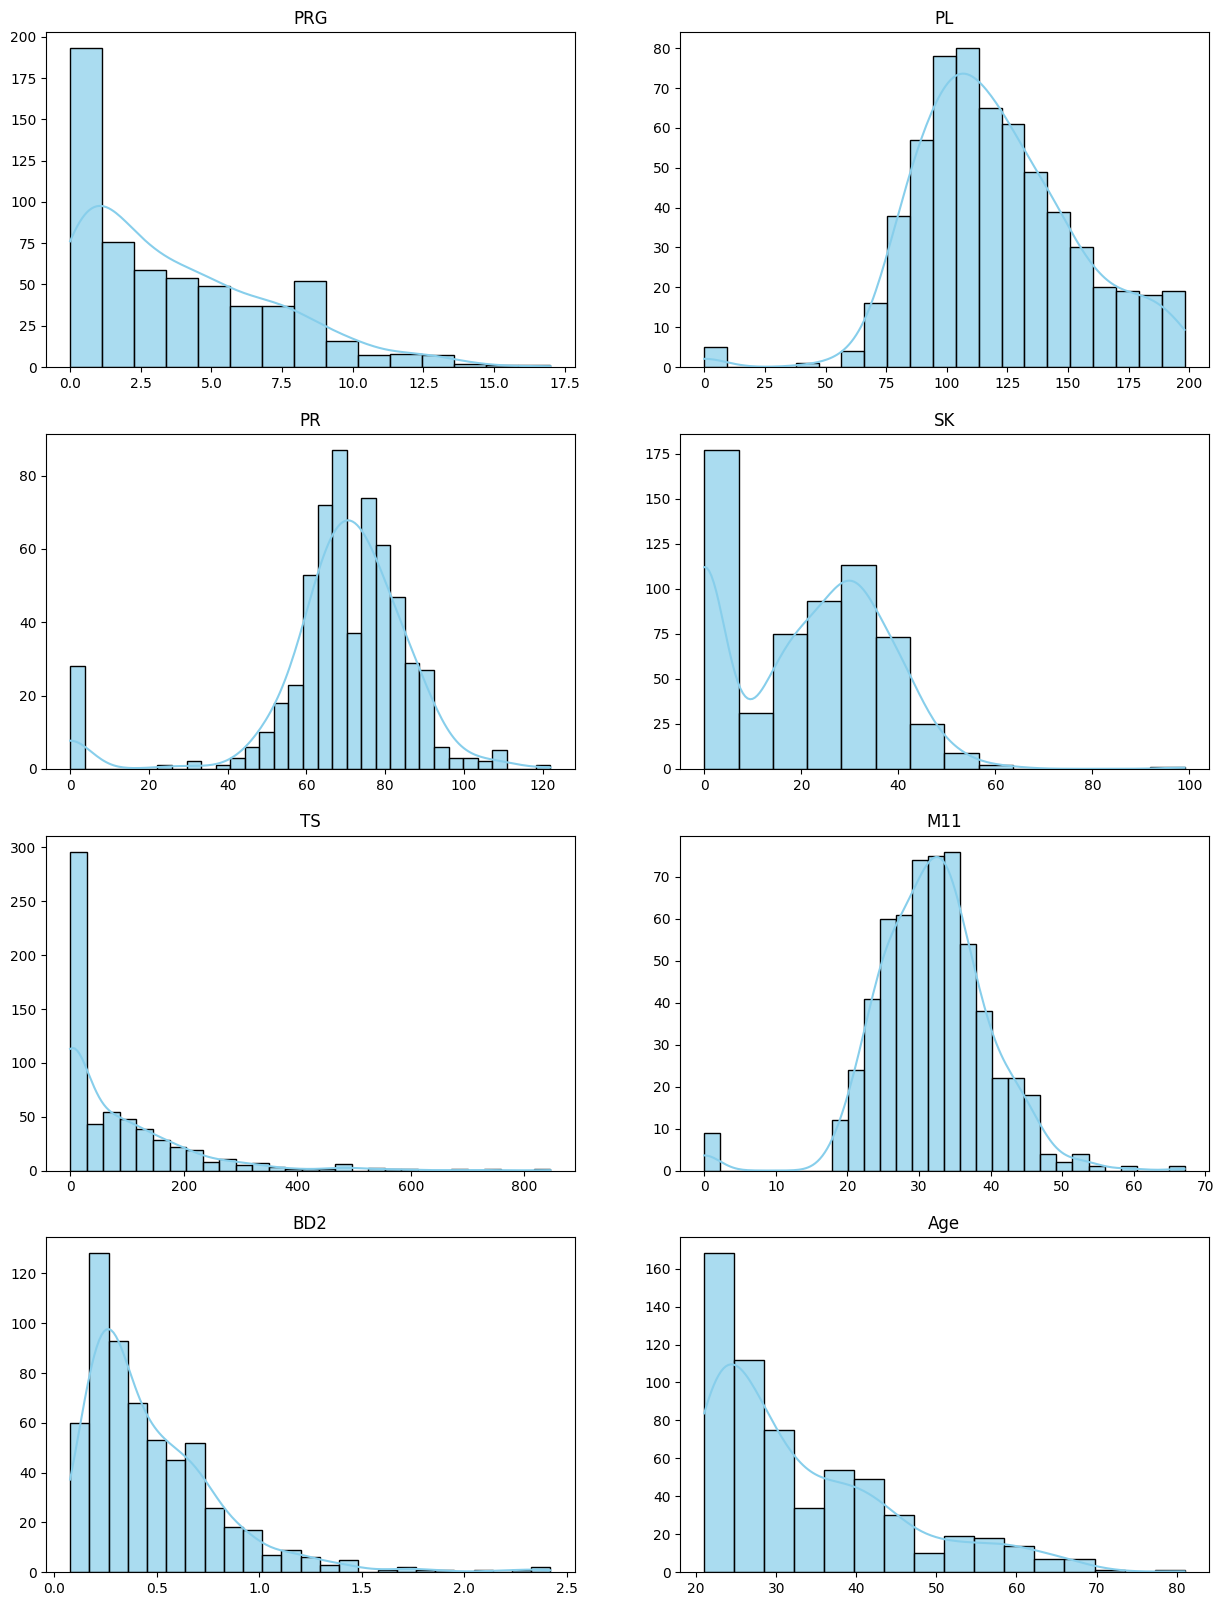

In [212]:
# Histplots to show distributions of data
num_rows, num_cols = 4, 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

for i, column in enumerate(df.drop(['ID', 'Insurance', 'Sepssis'], axis=1).columns):
    row, col = i // num_cols, i % num_cols
    sns.histplot(df[column], ax=axes[row, col], color='skyblue', kde=True, alpha=0.7, label='Skewness') 
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("")

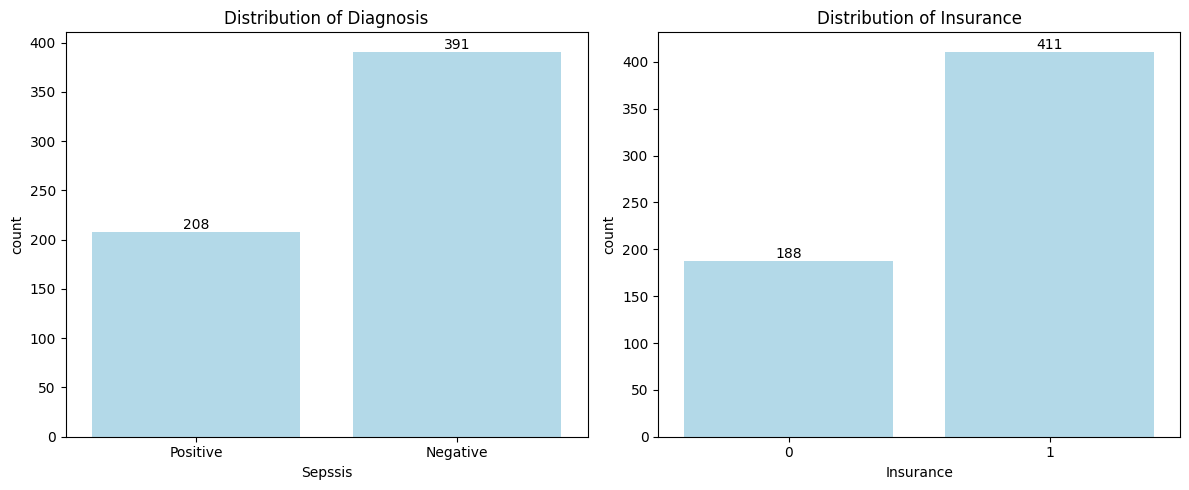

In [213]:
# Countplots to show distributions of Dianosis and Insurance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot: Distribution of Diagnosis
sns.countplot(x='Sepssis', data=df, ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Distribution of Diagnosis')
for i in axes[0].containers:
    axes[0].bar_label(i,)

# Second plot: Distribution of Diagnosis with respect to Insurance
sns.countplot(x='Insurance', data=df, ax=axes[1], color='skyblue', alpha=0.7)
axes[1].set_title('Distribution of Insurance')
for i in axes[1].containers:
    axes[1].bar_label(i,)

# Adjust layout
plt.tight_layout()
plt.show()


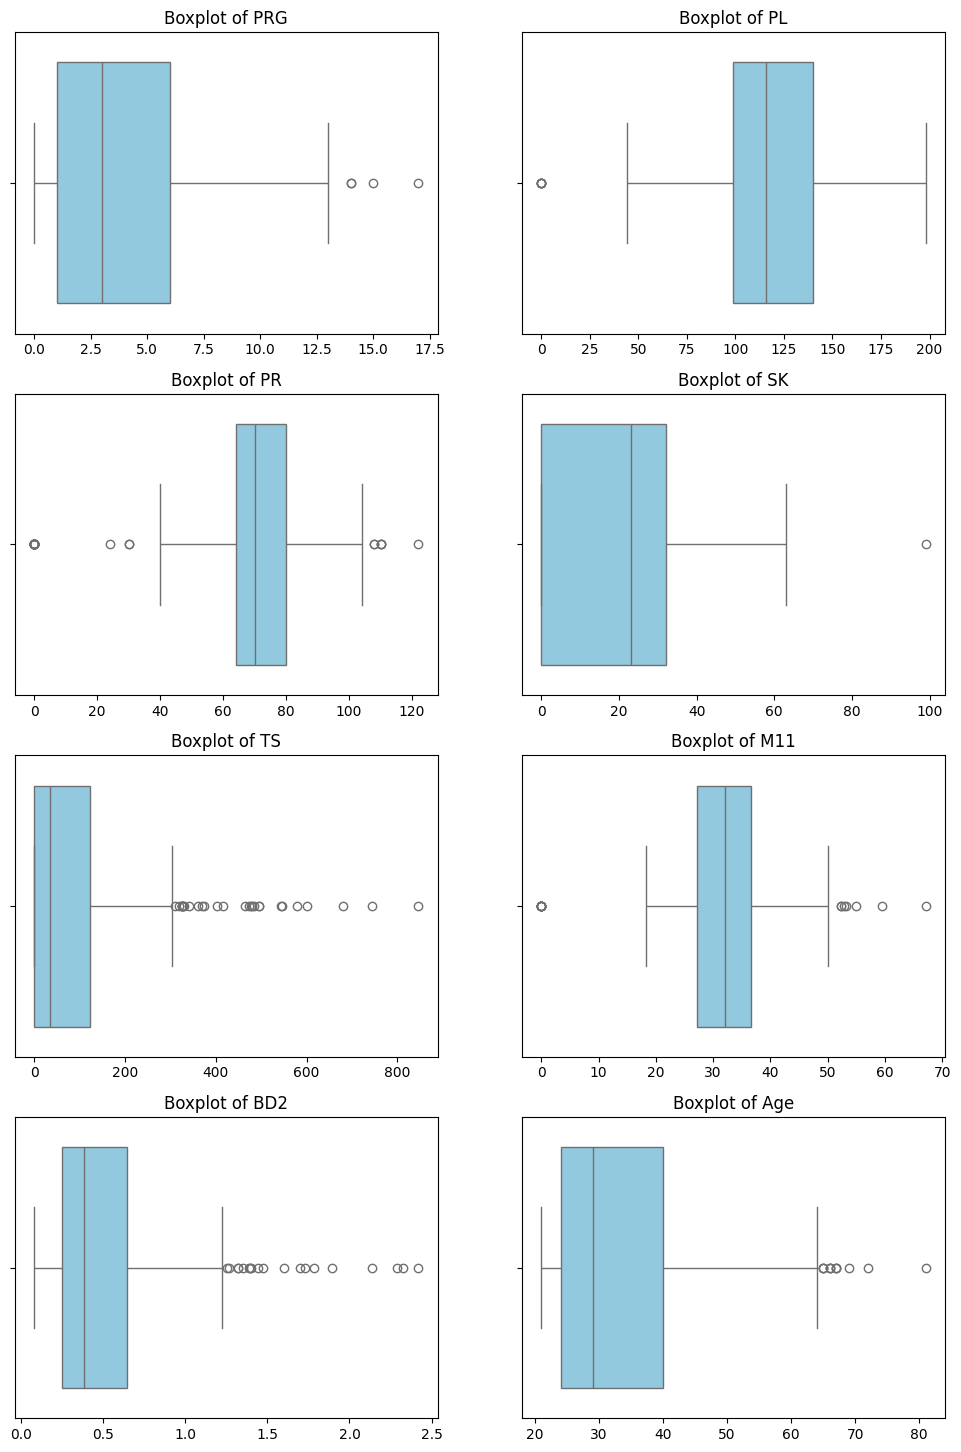

In [214]:
# Boxplots to show any outliers in the numerical columns
fig, ax = plt.subplots(4, 2, figsize=(12,18))

# Get numerical columns
num_cols = df.drop(['ID', 'Insurance'], axis=1).select_dtypes(include='number').columns

# Iterate over numerical columns
for i, column in enumerate(num_cols):
    row, col = i // 2, i % 2
    sns.boxplot(x=column, data=df, ax=ax[row, col], color='skyblue')
    ax[row, col].set_title(f'Boxplot of {column}')
    ax[row, col].set_xlabel("")
    

## Notes
- The dataset contains 11 columns and 599 rows
- There are no null values in the dataset
- There are no duplicated values in the dataset
- The top outcome is negative with a frequency of 391 against positive at 208
- Most of the blood work results (BD2, SK and Ts) assume a positive skewness. Only Blood work result-1 that assumes a negative skewness
- Body Mass Index (M11) is more normally distributed than not
- Plasma Glucose (PRG) is positively skewed
- Most patients turn negative to sepsis than postive
- Age is postively skewed, Number of patients decreases with increase in age
- Lasty, most patients have an insurance cover with most(411) having a cover against those without(188)
- Most of the numerical columns have outlier values

#### **Bivariate Analysis**

### **Analytical Questions**

### 1. Is there a significant correlation between age and the likelihood of developing sepsis?


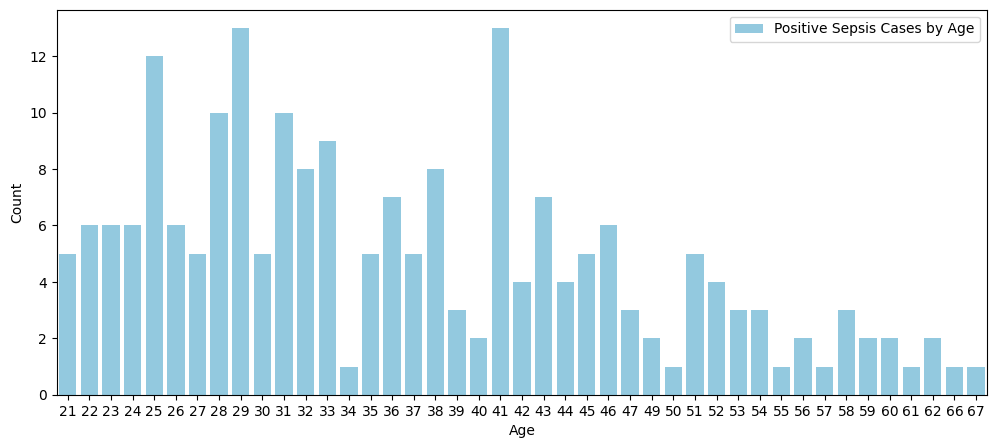

In [215]:
# Barplot to show relationship between age and the likelihood of developing sepsis
plt.figure(figsize=(12, 5)) 
positive_sepsis_by_age = df[df['Sepssis'] == 'Positive'].groupby('Age').size().reset_index(name='Count')
ax = sns.barplot(positive_sepsis_by_age, x='Age', y='Count', label='Positive Sepsis Cases by Age', color='skyblue')

### Notes
- There isn't any obvious Increase or decrease in the number of more postives as age increases. However, there are more postives between age 21 and 33, followed by ages 34 to 49 and the least number of postives comes from ages 50 and above
- We will have to narrow the ages to age groups for the trend to come out more clearly

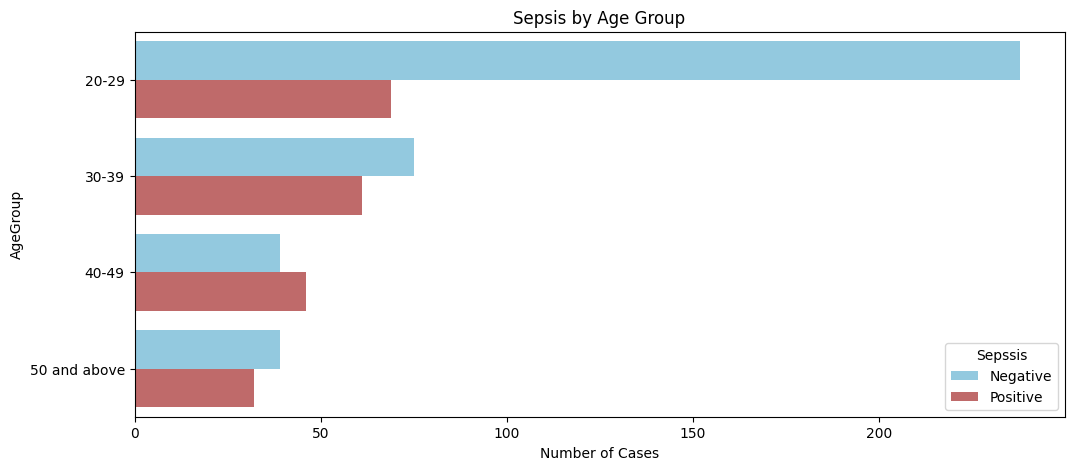

In [216]:
# Define age bins and labels
bins = [20, 30, 40, 50, float('inf')]
labels = ['20-29', '30-39', '40-49', '50 and above']

# Copy the df
df_copy = df.copy()

# Create age groups
df_copy['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
age_group_sepsis = df_copy.groupby(['AgeGroup', 'Sepssis'])['Sepssis'].size().reset_index(name='Number of Cases')

# PLot the grouped data
plt.figure(figsize=(12, 5))
sns.barplot(x='Number of Cases', y='AgeGroup', hue='Sepssis', data=age_group_sepsis, palette=['skyblue', 'indianred'],)
plt.title('Sepsis by Age Group')
plt.show()


### Notes
- When grouped with age groups, a trend becomes more obvious. An increase in age results to an decrease in number of positives
- There we can conclude that the younger a patients is, the more likely they are to develop Sepsis



### 2.  What is the relationship between blood pressure (PR) and the incidence of sepsis?


<Axes: xlabel='PR', ylabel='Count'>

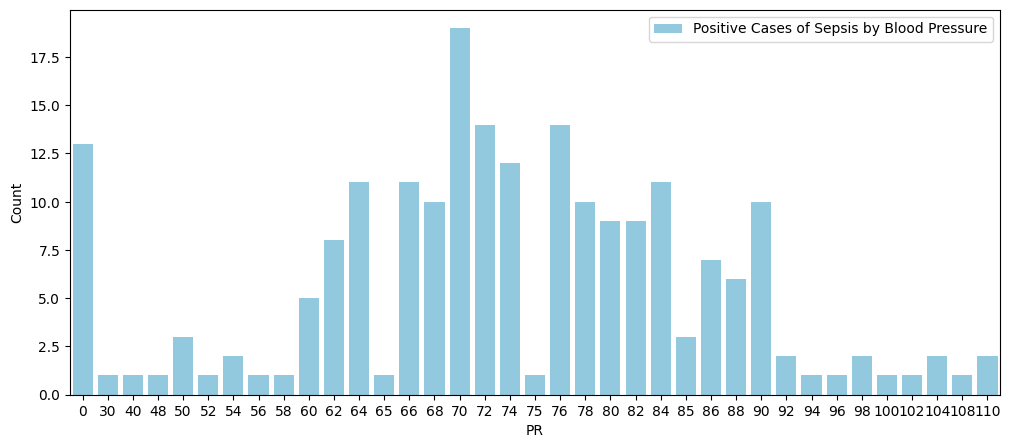

In [217]:
# Barplot to show how Blood pressure correlates to positive cases of sepssis
pr_sepsis = df[df['Sepssis']=='Positive'].groupby('PR')['Sepssis'].count().reset_index(name='Count')
plt.figure(figsize=(12,5))
sns.barplot(pr_sepsis, x='PR', y='Count', label='Positive Cases of Sepsis by Blood Pressure', color='skyblue')

### Notes
- Most positive cases come from the blood pressure of 0 and 70 (mm Hg).
- However most positive cases come from the blood pressure of range 60 (mm Hg) to 90 (mm Hg) with an exception of 65 75 and 85 (mm Hg) which have relatively few numbers of postive case

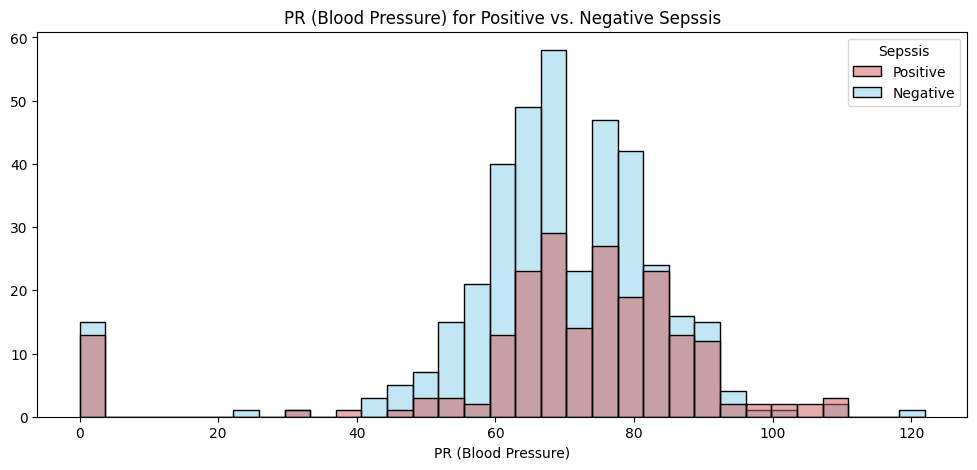

In [218]:
# Comparison of totals cases per PR reading against number of postive cases
# Create the histoplot
plt.figure(figsize=(12,5))
sns.histplot(hue='Sepssis', x='PR', data=df, fill=True, palette=['indianred', 'skyblue'])

# Label the axes
plt.ylabel('')
plt.xlabel('PR (Blood Pressure)')

# Show the plot
plt.title('PR (Blood Pressure) for Positive vs. Negative Sepssis')
plt.show()

### Notes
- After comparing positive and negative cases using a histoplot, we can conclude that infact, most postive cases come from 0 and the ranges of 60 to 90 (mm Hg)

### 3. What is the relationship between body mass index (BMI) and the development of sepsis? & What is the average Body mass index among patients who develop sepsis and who do not?

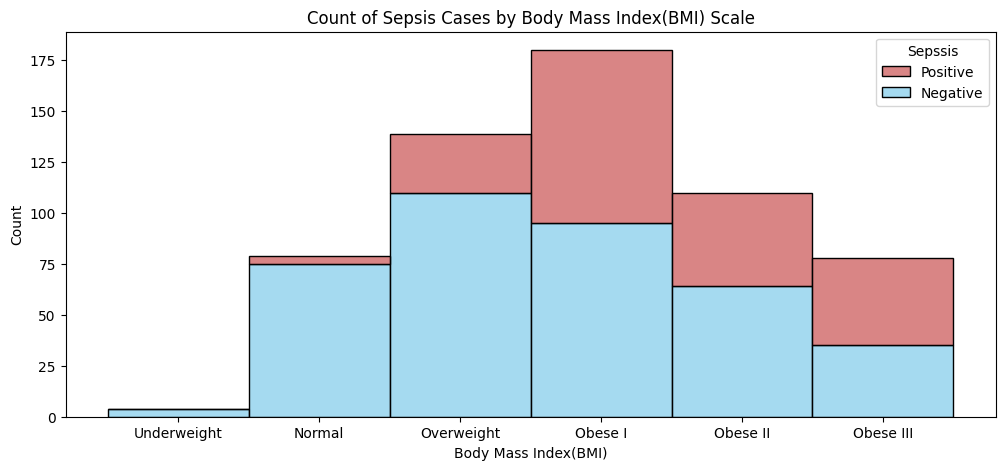

In [219]:
# Histplot to show the correlation between Body Mass Index (BMI) and the development	sepsis
df_copy['BMI'] = pd.cut(df['M11'], 
                              bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                    labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III'])

plt.figure(figsize=(12, 5))
sns.histplot(x='BMI', hue='Sepssis', data=df_copy, multiple='stack', palette=['indianred', 'skyblue'])

# Set labels and title
plt.xlabel('Body Mass Index(BMI)')
plt.ylabel('Count')
plt.title('Count of Sepsis Cases by Body Mass Index(BMI) Scale')

# Show the plot
plt.show()

In [220]:
# Average BMI for positive and negative sepsis cases

# Positive
# Assuming df_copy is your DataFrame
positive_sepsis_bmi_mean = df_copy[df_copy['Sepssis'] == 'Positive']['M11'].mean()

# Negative
negative_sepsis_bmi_mean = df_copy[df_copy['Sepssis'] == 'Negative']['M11'].mean()


print("Mean BMI for Positive Sepsis:", positive_sepsis_bmi_mean)
print("Mean BMI for Negative Sepsis:", negative_sepsis_bmi_mean)



Mean BMI for Positive Sepsis: 35.385576923076925
Mean BMI for Negative Sepsis: 30.076470588235292


### Notes:

- Majority of people who develop sepsis are overweight, and obese (All categories of obesity)

- The mean Body Mass Index (BMI) for positive cases is 35.4 while for negative cases is 30.1. Therefore it's safe to conclude that the higher the BMI the higher the chances of developing Sepsis

### 4. How is the distribution of plasma glucose (PRG) among patients who develop sepsis versus those who don't?


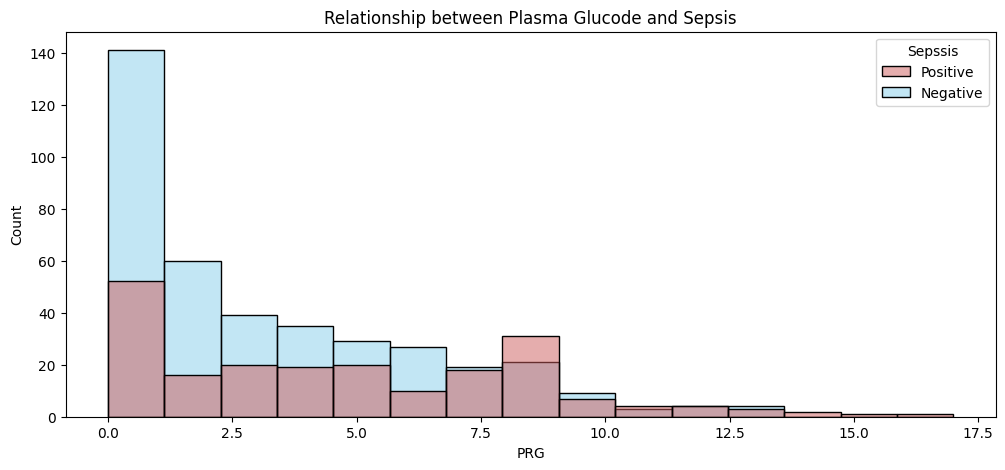

In [221]:
# Histoplot to show the relationship between Plasma Glucode (PRG) and Sepsis
plt.figure(figsize=(12, 5))
sns.histplot(x='PRG', hue='Sepssis', palette=['indianred', 'skyblue'], data=df)
plt.title('Relationship between Plasma Glucode and Sepsis')
plt.show()

### Notes:

- There is a clear correlation: higher plasma glucose levels (PRG) tend to coincide with a higher rate of sepsis positivity.
- Patients with elevated plasma glucose levels (PRG) are more likely to test positive for sepsis compared to those with lower PRG readings.
- These observations underscore the relationship between plasma glucose levels and sepsis positivity, highlighting the potential significance of PRG levels in sepsis diagnosis.

### 5. Which blood work parameters (PL, SK, TS, BD2) are most strongly associated with the development of sepsis?


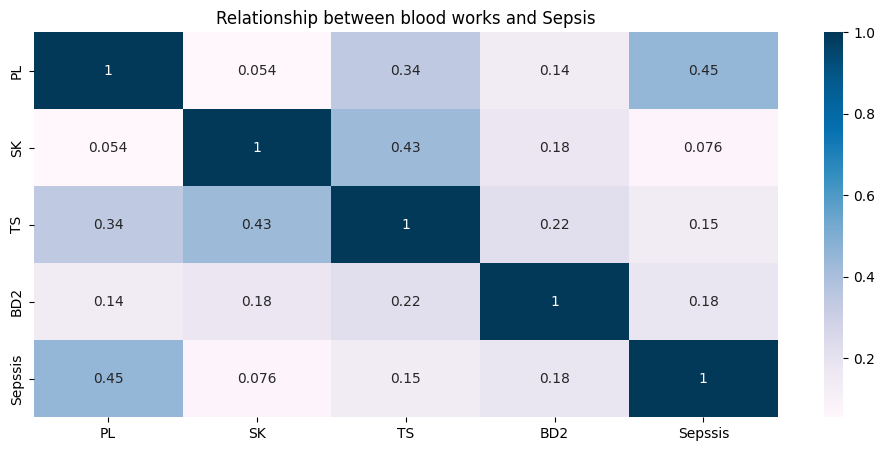

In [222]:
# Heatmap to show correlation between the parameters and sepsis development
df_copy['Sepssis'] = df_copy['Sepssis'].replace({'Positive' : 1, 'Negative': 0})

plt.figure(figsize=(12, 5))
sns.heatmap(df_copy.drop(['ID', 'PRG',  'PR','M11', 'Age', 'Insurance', 'AgeGroup', 'BMI'], axis=1).corr(), annot=True, cmap='PuBu')
plt.title('Relationship between blood works and Sepsis')
plt.show()



### Notes:

- Sepsis is mostly correlated with TS (Blood Work Result-3 (mu U/ml)) with a correlation of 0.45

- Second is PL (Blood Work Result-1 (mu U/ml)) With 0.34

- Third is BD2 (Blood Work Result-4 (mg/dl)) with 0.18

- And the least is SK (Blood Work Result-2 (mu U/ml)) with 0.076

Since using correlation matrix we can only infer much about the general correlation, we will narrow down the corretion using histplots to see how the parameters

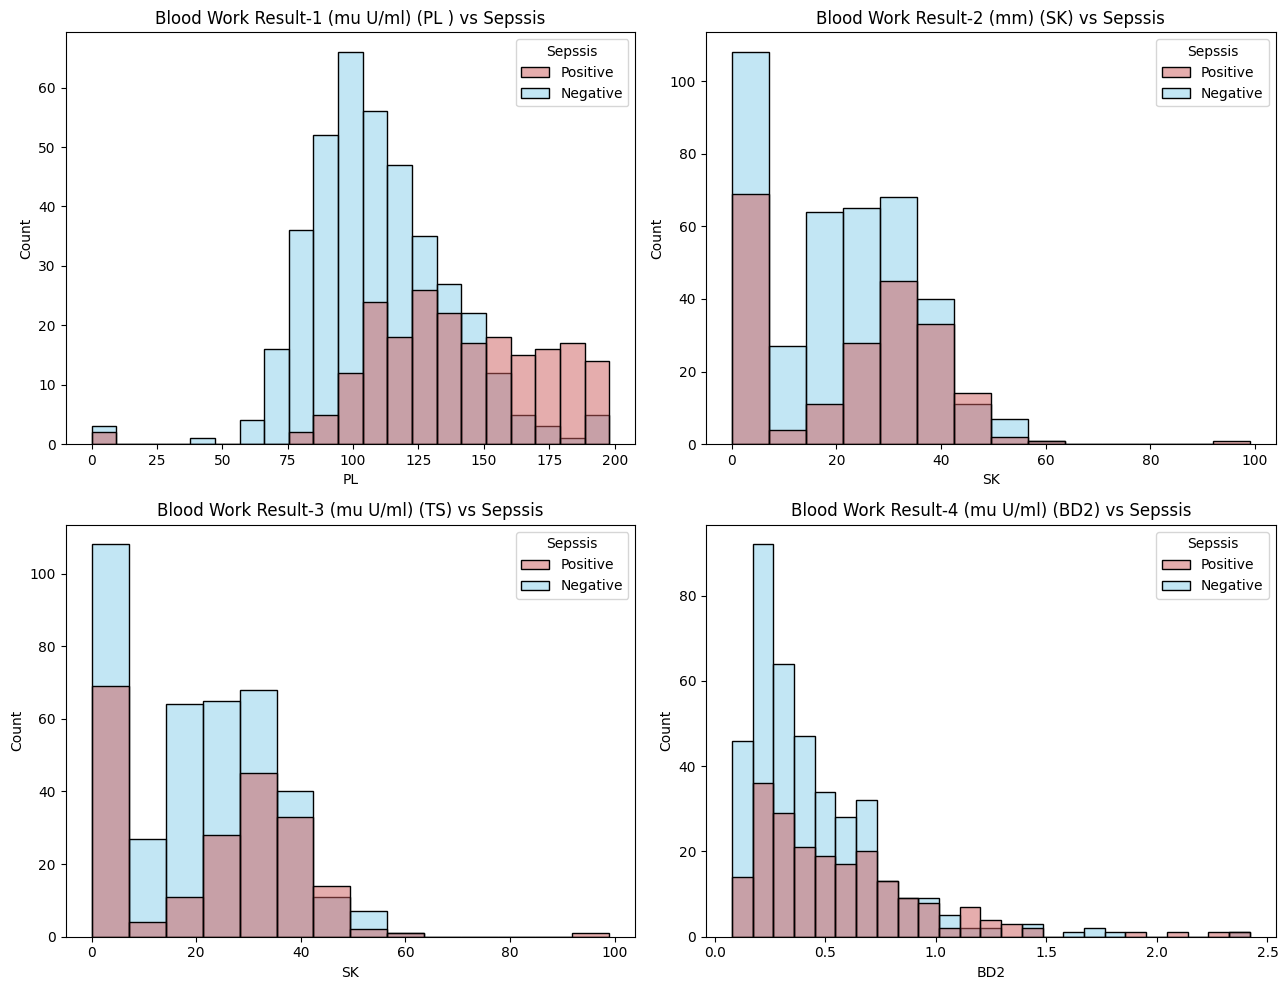

In [223]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

# Create the strip plots
sns.histplot(ax=axes[0, 0], hue='Sepssis', x='PL', data=df, fill=True, palette=['indianred', 'skyblue'])
sns.histplot(ax=axes[0, 1], hue='Sepssis', x='SK', data=df, fill=True, palette=['indianred', 'skyblue'])
sns.histplot(ax=axes[1, 0], hue='Sepssis', x='SK', data=df, fill=True, palette=['indianred', 'skyblue'])
sns.histplot(ax=axes[1, 1], hue='Sepssis', x='BD2', data=df, fill=True, palette=['indianred', 'skyblue'])

# Set titles for each subplot
axes[0, 0].set_title('Blood Work Result-1 (mu U/ml) (PL ) vs Sepssis')
axes[0, 1].set_title('Blood Work Result-2 (mm) (SK) vs Sepssis')
axes[1, 0].set_title('Blood Work Result-3 (mu U/ml) (TS) vs Sepssis')
axes[1, 1].set_title('Blood Work Result-4 (mu U/ml) (BD2) vs Sepssis')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### Notes
- The higher the readings of Blood Work Result-1 (mu U/ml) (PL) the more likely that the patient will develop sepsis
- 0 and the ranges of 30 to 50 in Blood Work Result-2 (mm) (SK) and Blood Work Result-3 (mu U/ml) (TS) mostly leads to developments of sepsis more often than other values
- The higher the readings of Blood Work Result-4 (mu U/ml) (BD2), the more likely that the patient will develop sepsis

### Multivariate Analysis

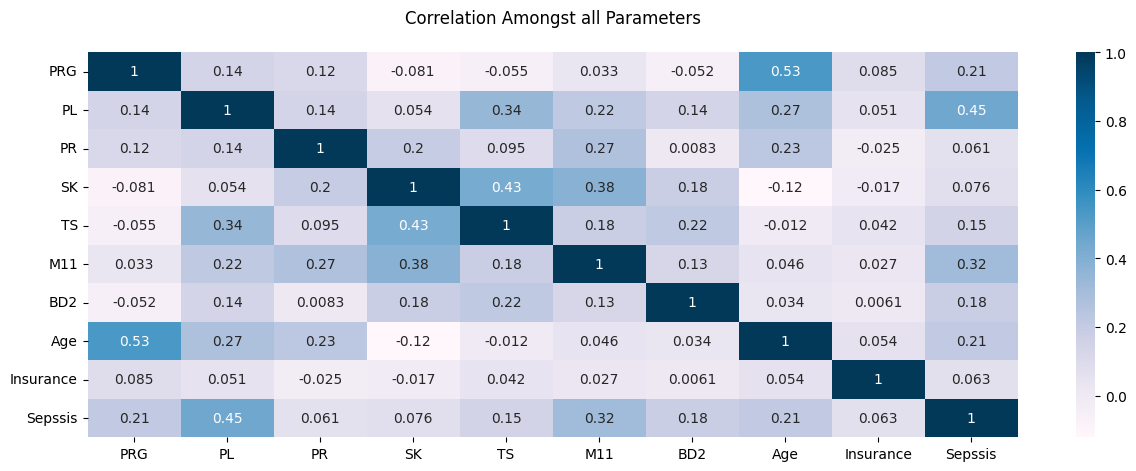

In [224]:
# Heatmap to show correlation of all the parameters
plt.figure(figsize=(15,5))
sns.heatmap(df_copy.drop(['ID', 'AgeGroup', 'BMI'], axis=1).corr(), annot=True, cmap='PuBu')
plt.title("Correlation Amongst all Parameters\n")
plt.show()

### Notes
- The highest correlation is between Plasma Glulose (PRG) AND Sepsis at 0.53
- The second highest correlation is between is between Sepsis and Blood work result 1 (PL)

### **Hypothesis Testing**

**Null Hypotheisi (H0)**  - There is no significant correlation between blood pressure and sepsis  
 **Alternative Hypothesis (H1)** - There is a significant correlation between blood pressure and sepsis

In [225]:
# Calculate the point-biserial correlation
correlation, p_value = pointbiserialr(df_copy['Sepssis'], df_copy['PR'])

print(f'Correlation coefficient: {correlation:.5f}')
print(f'P-value: {p_value:.5f}')

# Interpret the result
alpha = 0.01
if p_value < alpha:
    print("Reject the null hypothesis (H0). \nThere is a correlation between blood pressure (PR) and sepsis.")
else:
    print("Fail to reject the null hypothesis (H0). \nThere is no correlation between blood pressure (PR) and sepsis.")


Correlation coefficient: 0.06109
P-value: 0.13535
Fail to reject the null hypothesis (H0). 
There is no correlation between blood pressure (PR) and sepsis.


### Notes
The point-biserial correlation is used to measure the relationship between a binary variable (x) and a continuous variable (y). Like other correlation coefficients, this one varies between -1 and +1, with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.(A determinative relationship means that one factor directly causes another to happen.)  


In our case, a p-value of 0.13535 implies that there is no significant correlation (Values close to 0 indicate no correlation) between blood pressure (PR) and sepsis. Specifically, because the p-value is greater than the common significance level (alpha = 0.05), we fail to reject the null hypothesis (H0). This means that any observed correlation is likely due to chance rather than a true underlying relationship.

## **`Data Preparation`**

In [226]:
# Change Sepssis to Sepsis
df['Sepsis'] = df['Sepssis']

# Drop the ID and Sepssis columns which are irrelevant for machine learning
df = df.drop(['ID', 'Sepssis'], axis=1)

# Convert Insurance column to categorical

df['Insurance'] = df['Insurance'].replace({0 : 'No', 1 : 'Yes'})

In [227]:
# Define numerical columns
numerical_columns = df.select_dtypes('number')

# Define categorical columns
categorical_columns = df.select_dtypes('object')

print(f'Numerical Columns: {numerical_columns.columns}')
print(f'Categoriacl Columns: {categorical_columns.columns}')


Numerical Columns: Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')
Categoriacl Columns: Index(['Insurance', 'Sepsis'], dtype='object')


#### Data Splitting

In [228]:
# Define X
X = df.drop('Sepsis', axis=1)

# Define y
y = df['Sepsis']


In [229]:
y.head()

0    Positive
1    Negative
2    Positive
3    Negative
4    Positive
Name: Sepsis, dtype: object

In [230]:
X.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,6,148,72,35,0,33.6,0.627,50,No
1,1,85,66,29,0,26.6,0.351,31,No
2,8,183,64,0,0,23.3,0.672,32,Yes
3,1,89,66,23,94,28.1,0.167,21,Yes
4,0,137,40,35,168,43.1,2.288,33,Yes


In [231]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [232]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Encode y
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [233]:
# Create a numerical pipeline
num_pipeline = Pipeline(steps=[
                         ('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler(), numerical_columns),
                         ('transformer', FunctionTransformer(np.log1p), numerical_columns)
                         ])


# Create a categorical pipeline
cat_pipeline = Pipeline(steps=[
                         ('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
                         ])


# Combine the pipelines
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, numerical_columns),
                                               ('cat', cat_pipeline, categorical_columns)])

## **`Modelling`**

In [234]:
# Define Random Forest Classifier Pipeline
rfc = RandomForestClassifier(random_state=42)
rfc_pipeline = Pipeline(steps=[
                         ('preprocessor', preprocessor),
                          ('rfc', rfc)
                          ])

In [235]:
rfc_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler(),
                                                                        PRG   PL  PR  SK   TS   M11    BD2  Age
0      6  148  72  35    0  33.6  0.627   50
1      1   85  66  29    0  26.6  0.351   31
2      8  183  64   0    0  23.3  0.672   32
3      1   89  66  23   94  28.1  0.167   21
4      0  137  40  35  168  43.1  2.288   33
..   ...  ...  ..  ..  ...   ...    ...  ...
594    6  123  72  45  230  33.6  0.733   34
595    0  188  82  14  185  32.0  0.682   22
596    0   67  76   0...
2         Yes  Positive
3         Yes  Negative
4         Yes  Positive
..        ...       ...
594        No  Negative
595       Yes  Positive
596       Yes  Negative
597        No  Negative
598       Yes  Positive

[599 rows x 2 columns])]),
                                                      Insurance    Sepsis
0          No  Positive
1          No  Negative
2         Yes  Positive
3         Yes  Negative
4         Yes  Positive
..        ...       ...
594        No  Negative
595       Yes  Positive
596       Yes  Negative
597        No  Negative
598       Yes  Positive

[599 rows x 2 columns])])),
                ('rfc', RandomForestClassifier(random_state=42))])